<a href="https://colab.research.google.com/github/DenyT17/Football_Object_Detection/blob/main/Football_Object_Detection_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Football tracking detection with YOLOv8 and BYTETracker**


## **Installing required libraries**


In [ ]:
!pip install ultralytics
from __future__ import annotations
import math
from typing import Generator
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import cv2 as cv
from google.colab import drive
import os
import numpy as np
%matplotlib inline
from ultralytics import YOLO
from dataclasses import dataclass, field
import math
import numpy as np
from typing import Tuple, Optional, List, Dict, Any
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Connecting with google drive**

In [ ]:
drive.mount('/content/gdrive')

ROOT_DIR = '/content/gdrive/My Drive/Football_Detection'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Loading an early trained model**

In [ ]:
model = YOLO("/content/gdrive/MyDrive/Football_Detection/runs/detect/train2/weights/best.pt")

## **Loading image and video**

In [ ]:
video = "/content/gdrive/My Drive/Football_Detection/video/finall"
img = cv.imread("/content/gdrive/My Drive/Football_Detection/test/images/573e61_9_6_png.rf.f7756714cdfe79da92e3e99837b7b655.jpg")

## **Defining classes, methods and functions which will be used to objects detection**

In [ ]:
@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

@dataclass
class Detection:
    rect:Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: List[str]) -> List[Detection]:
        result = []
        for r in pred:
          boxes = r.boxes
          for box in boxes:
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            result.append(Detection(
                rect=Rect(
                    x=float(x1),
                    y=float(y1),
                    width=float(x2 - x1),
                    height=float(y2 - y1)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=math.ceil((box.conf[0] * 100)) / 100
            ))
        return result
  

In [ ]:
@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

def draw_shape(image: np.ndarray, rect: Rect,conf: float,name: str, color: Color, thickness: int = 2) -> np.ndarray:
  bottom_center_x = int(rect.x + rect.width/2)
  bottom_center_y = int(rect.y + rect.height)
  cv.ellipse(
      image,
      center=(bottom_center_x,bottom_center_y),
      axes=(int(rect.width), int(0.4 * rect.width)),
      angle=0.0,
      startAngle=-45,
      endAngle=235,
      color=color,
      thickness=thickness,
      lineType=cv.LINE_4
  )


  return image

Ball_posesion_range = 30
MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

def calculate_marker(x: int,y:int) -> np.ndarray:
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv.drawContours(image, [countour], 0, color, thickness)
    return image

def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv.drawContours(image, [countour], 0, color, -1)
    return image

def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]

def ball_in_posesion(x_ball: int,y_ball: int, x_player: int,y_player: int, proximity: int):
  if x_player - proximity < x_ball <  x_player + proximity and y_player - proximity < y_ball <  y_player + proximity:
    return True
  else:
    return False

def get_player_in_possession(
    player_detections: List[Detection], 
    ball_detections: List[Detection],
    proximity: int) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    x_ball,y_ball = int(ball_detection.rect.x + ball_detection.rect.width/2),int(ball_detection.rect.y + ball_detection.rect.height)
    for player_detection in player_detections:
      x_player,y_player = int(player_detection.rect.x + player_detection.rect.width/2), int(player_detection.rect.y + player_detection.rect.height)
      if ball_in_posesion(x_ball,y_ball, x_player,y_player, proximity):
        return player_detection

def draw_marker(image: np.ndarray,x: int,y: int, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(x,y)

    image = draw_filled_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=color)
    image = draw_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=Ball_color,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image

In [ ]:
@dataclass
class BaseAnnotator:
    colors: Color
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection],player_with_posesion: Optional[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            top_center_x = int(detection.rect.x + detection.rect.width/2)
            top_center_y = int(detection.rect.y)
            annotated_image = draw_shape(
                image=image,
                rect=detection.rect,
                conf=detection.confidence,
                name=detection.class_name,
                color=self.colors[detection.class_id],
                thickness=self.thickness)
            
            
            if detection == player_with_posesion:
              annotated_image = draw_marker(
                  image=annotated_image, 
                  x=top_center_x,
                  y=top_center_y,
                  color=self.colors[detection.class_id])
              
            if detection.class_name == "ball":
              annotated_image = draw_marker(
                  image=annotated_image, 
                  x=top_center_x,
                  y=top_center_y,
                  color=self.colors[detection.class_id])
  
        return annotated_image

def plot_image(image: np.ndarray, size: int = 12) -> None:
  plt.figure(figsize=(size, size))
  plt.imshow(image[...,::-1])
  plt.show()

## **Detection of objects in the image**

In [ ]:
prediction = model(img)
detections = Detection.from_results(
    pred=prediction,
    names=model.names)
print(detections)


0: 640x640 1 goalkeeper, 17 players, 4 referees, 35.9ms
Speed: 7.8ms preprocess, 35.9ms inference, 60.3ms postprocess per image at shape (1, 3, 640, 640)


[Detection(rect=Rect(x=1212.0, y=1159.0, width=35.0, height=110.0), class_id=3, class_name='referee', confidence=0.91, tracker_id=None), Detection(rect=Rect(x=290.0, y=950.0, width=31.0, height=84.0), class_id=2, class_name='player', confidence=0.91, tracker_id=None), Detection(rect=Rect(x=586.0, y=584.0, width=17.0, height=57.0), class_id=2, class_name='player', confidence=0.9, tracker_id=None), Detection(rect=Rect(x=659.0, y=493.0, width=16.0, height=51.0), class_id=2, class_name='player', confidence=0.89, tracker_id=None), Detection(rect=Rect(x=821.0, y=857.0, width=31.0, height=79.0), class_id=2, class_name='player', confidence=0.89, tracker_id=None), Detection(rect=Rect(x=1089.0, y=655.0, width=16.0, height=72.0), class_id=2, class_name='player', confidence=0.88, tracker_id=None), Detection(rect=Rect(x=453.0, y=532.0, width=15.0, height=56.0), class_id=2, class_name='player', confidence=0.88, tracker_id=None), Detection(rect=Rect(x=745.0, y=814.0, width=33.0, height=74.0), class_i

## **Annotating object and showing results**

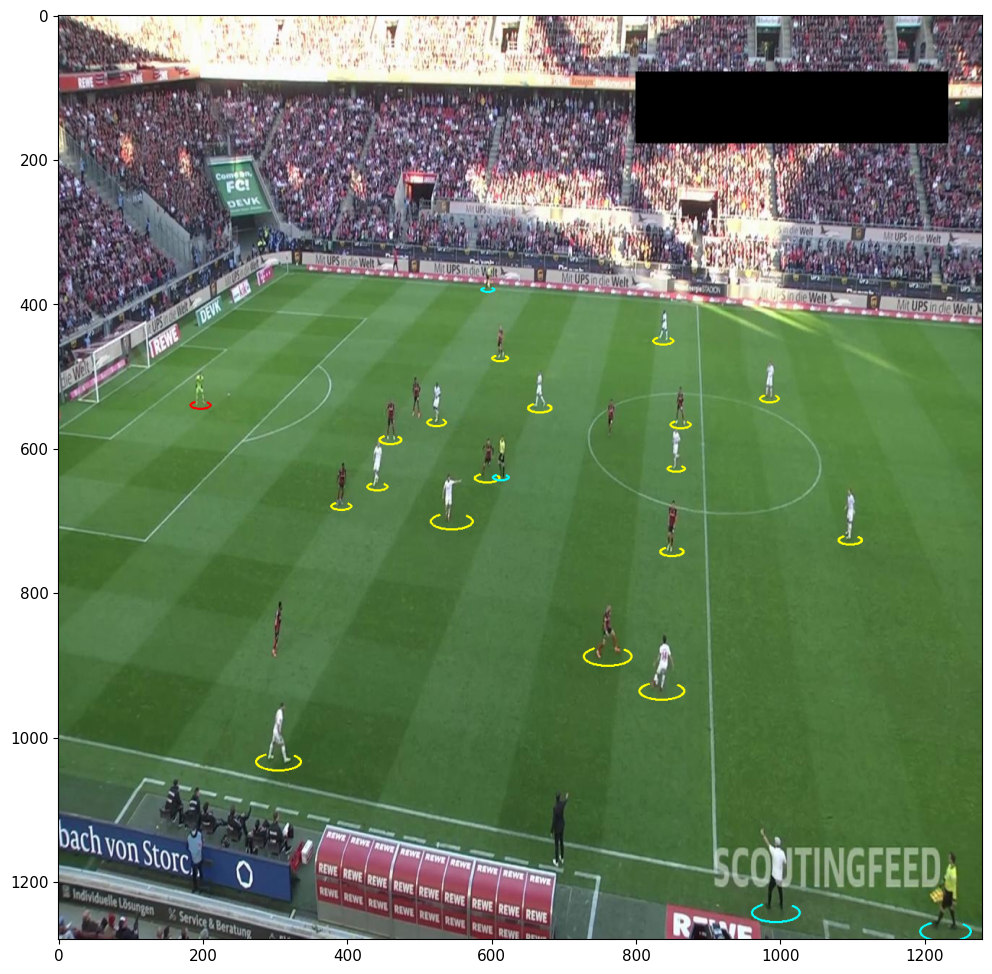

In [ ]:

Ball_color = (255,0,0)
Goalkeeper_color = (0,0,255)
Players_color = (0,255,255)
Refrees_color = (255,255,0)

ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
Colors = [
    Ball_color,
    Goalkeeper_color,
    Players_color,
    Refrees_color   
]

annotator = BaseAnnotator(
    colors=Colors, 
    thickness=2)

image_with_detection = annotator.annotate(
    image=img, 
    detections=detections,
    player_with_posesion = player_in_possession_detection)

plot_image(image_with_detection)

## **Detection and annotating of objects in the video, and create new video with detected objects.**

In [ ]:
def pred_and_save(video:str):
    video_path = os.path.join(f"{video}.mp4")
    video_path_out = '{}_out.mp4'.format(video)

    cap = cv.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv.VideoWriter(video_path_out, cv.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv.CAP_PROP_FPS)), (W, H))
    classNames = ['ball', 'goalkeeper', 'player', 'referee']
    while ret:
        prediction = model(frame)
        detections = Detection.from_results(pred=prediction,names=model.names)
        ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
        player_detections = filter_detections_by_class(detections=detections, class_name="player")
        player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
        annotator = BaseAnnotator(colors=Colors, thickness=2)
        image_with_detection = annotator.annotate(image=frame, detections=detections,player_with_posesion = player_in_possession_detection)
        out.write(image_with_detection)
        ret, frame = cap.read()
    cap.release()
    out.release()
    cv.destroyAllWindows()
    print(f"{video_path_out} saved")

pred_and_save(video)



0: 384x640 1 goalkeeper, 18 players, 2 referees, 1406.1ms
Speed: 0.8ms preprocess, 1406.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 18 players, 2 referees, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 20 players, 2 referees, 8.4ms
Speed: 0.6ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 7.4ms
Speed: 0.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 0.6ms preprocess,

/content/gdrive/My Drive/Football_Detection/video/finall_out.mp4 saved


# **Tracking objects**

In [ ]:
from dataclasses import dataclass

!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

!pip install onemetric --quiet
!pip install loguru
!pip install utils
!pip install lap
!pip install yolox


Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
Updating files: 100% (229/229), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting req

In [ ]:
import sys
sys.path.append(f"/root/ByteTrack") 

In [ ]:
import torch
import utils
import lap
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

[Errno 2] No such file or directory: '/root/ByteTrack'
/content/gdrive/MyDrive/Football_Detection/footballanalysis/Bird's eye view


ModuleNotFoundError: ignored

# **Converting detection into format that can be used in match detection with track** 

In [ ]:
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.x, 
            detection.rect.y,
            detection.rect.x + detection.rect.width,
            detection.rect.y + detection.rect.height,
            detection.confidence
        ] if with_confidence else [
            detection.rect.x, 
            detection.rect.y,
            detection.rect.x + detection.rect.width,
            detection.rect.y + detection.rect.height,
        ]
        for detection
        in detections
    ], dtype=float)

def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
      track.tlbr
      for track
      in tracks
    ], dtype=float)

## **Function to match detection and tracking** 

In [ ]:
def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

## **Creating class thank to which tracking text will be adding**

In [ ]:
@dataclass
class TrackAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            if detection.tracker_id is None:
                continue

            size, _ = cv.getTextSize(
                str(detection.tracker_id), 
                cv.FONT_HERSHEY_SIMPLEX, 
                0.7, 
                thickness=self.text_thickness)
            width, height = size
            
            top_left_x = int(detection.rect.x)
            top_left_y = int(detection.rect.y - detection.rect.height/3)
            bottom_right_x = int(detection.rect.x + 40)
            bottom_right_y = int(detection.rect.y)

            annotated_image = cv.rectangle(annotated_image,
                                           (top_left_x,top_left_y), 
                                           (bottom_right_x,bottom_right_y),
                                           self.background_color, -1)

            annotated_image = cv.putText(annotated_image,
                                         str(detection.tracker_id),
                                         (top_left_x,bottom_right_y),
                                         cv.FONT_HERSHEY_SIMPLEX,
                                         0.7, self.text_color,
                                         self.text_thickness, 2, False)

        return annotated_image

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## **Tracking object on single image**

In [ ]:
def track_img(img: numpy.ndarray):
  byte_tracker = BYTETracker(BYTETrackerArgs())
  track_annotator = TrackAnnotator(background_color=(255, 255, 255), text_color=(0, 0, 0), text_thickness=2)

  results =  model(img)
  detections = Detection.from_results(
      pred=prediction,
      names=model.names)

  goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
  player_detections = filter_detections_by_class(detections=detections, class_name="player")
  player_detections = player_detections + goalkeeper_detections
      
  tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=img.shape,
        img_size=img.shape
      )
  player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)


  annotated_image = img.copy()
  annotated_image = track_annotator.annotate(
        image=annotated_image, 
        detections=player_detections)
  plot_image(annotated_image)

track_img(img)

## **Saving video with detected and tracked objects**

In [ ]:

def save_video_det_tr(video:str):

    Ball_color = (255,0,0)
    Goalkeeper_color = (0,0,255)
    Players_color = (0,255,255)
    Refrees_color = (255,255,0)
    video_path = os.path.join(f"{video}.mp4")
    video_path_out = '{}_out.mp4'.format(video)

    byte_tracker = BYTETracker(BYTETrackerArgs())

    track_annotator = TrackAnnotator(background_color=(255, 255, 255), text_color=(0, 0, 0), text_thickness=2)

    cap = cv.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv.VideoWriter(video_path_out, cv.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv.CAP_PROP_FPS)), (W, H))
    classNames = ['ball', 'goalkeeper', 'player', 'referee']
    while ret:
        prediction = model(frame)

        
        detections = Detection.from_results(pred=prediction,names=model.names)
        ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
        player_detections = filter_detections_by_class(detections=detections, class_name="player")
        goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")

        player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
        
        tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=img.shape,
        img_size=img.shape
        )

        player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)

        annotator = BaseAnnotator(colors=Colors, thickness=2)
        image_with_detection = annotator.annotate(image=frame, detections=detections,player_with_posesion = player_in_possession_detection)
        image_with_detection = track_annotator.annotate(
                                                        image=image_with_detection, 
                                                        detections=player_detections)
        out.write(image_with_detection)
        ret, frame = cap.read()
    cap.release()
    out.release()
    cv.destroyAllWindows()
    print(f"{video_path_out} saved")

save_video_det_tr(video)